## Installing dependencies

In [1]:
# Check PyTorch version installed on this system
!python -c "import torch; print(torch.__version__)"

2.1.0+cu121


In [2]:
# Download the corresponding PyTorch Geometric module
%%capture
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=2.1.0+cu121
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [3]:
# Let's first import all the things we are gonna need for this task
import torch
import time
import torch.nn as nn
import numpy as np
import random
from tqdm.auto import trange

from torch_scatter import scatter
from torch_geometric.nn import MessagePassing
import torch_geometric.utils as U

# torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import DataLoader
from torch_geometric.data.data import Data
import torch_geometric.utils as U
from sklearn.metrics import roc_auc_score
from torch_geometric.datasets import TUDataset


import torch
import torch.nn.functional as F
from torch_geometric.logging import init_wandb, log

# models ready to compare
from torch_geometric.nn import GCNConv,GraphConv,GINConv,MLP,global_mean_pool,global_add_pool
from torch_geometric.nn.models import GCN
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
import networkx as nx
import matplotlib.pyplot as plt

## Loading dataset

In [4]:
# please **DO NOT** modify  any part of the following code  in this cell
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])


Done!


/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


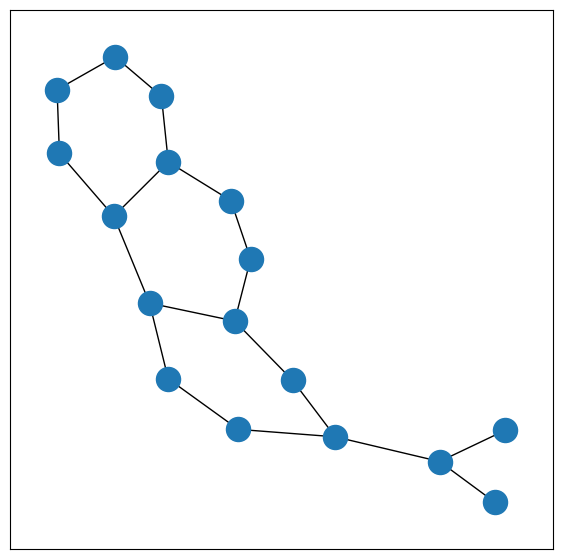

In [5]:
# visualize one
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     cmap="Set2")
    plt.show()

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

##  Setting parameters

In [31]:
# all models' parameters
params = {
    "input_features": 7,
    "hidden_features_gin": 64,
    "hidden_features_gcn": 64,
    "hidden_features_kgnn": 64,
    "num_gin_layers": 3,
    "num_gcn_layers": 2,
    "num_mlp_layers": 2,
    "learning_rate": 1e-4,
    "weight_decay": 0,
    "num_epochs": 256,
    "num_classes": 2,
    "batch_size": 32,
}

# device to use
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')


# data loader
torch.manual_seed(12345)
dataset = dataset.shuffle()

## Models

### GCN

In [39]:
# Model1: GCN
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x


### GIN

In [36]:
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            mlp = MLP([in_channels, hidden_channels, hidden_channels])
            self.convs.append(GINConv(nn=mlp, train_eps=False))
            in_channels = hidden_channels

        self.mlp = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = global_mean_pool(x, batch)
        return self.mlp(x)

### K-GNN

In [40]:
# Model3: k-GNN
class kGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(kGNN, self).__init__()

        self.conv1 = GraphConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

## Experiment 1: Compare Different Models

In [41]:
# Model1: GCN
def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        total_loss += float(loss) * data.num_graphs
        optimizer.zero_grad()  # Clear gradients.
    return total_loss / len(train_loader.dataset)


def test(loader):
     model.eval()

     correct = 0
     loss_ = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)
         loss = criterion(out, data.y)
         loss_ += loss.item()
         pred = out.argmax(dim=1)  # Use the class with highest probability.

         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset), loss_ / len(loader.dataset)  # Derive ratio of correct predictions.

# 10-fold cv
each_group_samples = len(dataset)//10

k_scores = [0,0,0]
k_times = []
for group_i in range(10):
    start = group_i * each_group_samples
    end = (group_i + 1) * each_group_samples

    train_dataset = dataset[:start] + dataset[end:]
    test_dataset = dataset[start:end]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = GCN(params["hidden_features_gcn"]).to(device)

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=params["learning_rate"],
                                weight_decay=params["weight_decay"])
    criterion = nn.CrossEntropyLoss()

    times = []
    for epoch in range(1, params["num_epochs"] + 1):
        start = time.time()
        loss = train()
        train_acc, _ = test(train_loader)
        test_acc, _ = test(test_loader)
        if epoch == params["num_epochs"]:
            k_scores[0]+=loss
            k_scores[1]+=train_acc
            k_scores[2]+=test_acc
        log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
        times.append(time.time() - start)
    k_times.append(torch.tensor(times).median())

print('')
print(f'10-fold cross validation   Epoch:256    Loss:{k_scores[0]/10:.2f},    Train:{k_scores[1]/10:.2f},    Test:{k_scores[2]/10:.2f}')
print(f'Median time per epoch: {sum(k_times)/10:.4f}s')

Epoch: 001, Loss: 0.6931, Train: 0.6588, Test: 0.7222
Epoch: 002, Loss: 0.6926, Train: 0.6588, Test: 0.7222
Epoch: 003, Loss: 0.6882, Train: 0.6588, Test: 0.7222
Epoch: 004, Loss: 0.6864, Train: 0.6588, Test: 0.7222
Epoch: 005, Loss: 0.6864, Train: 0.6588, Test: 0.7222
Epoch: 006, Loss: 0.6854, Train: 0.6588, Test: 0.7222
Epoch: 007, Loss: 0.6824, Train: 0.6588, Test: 0.7222
Epoch: 008, Loss: 0.6803, Train: 0.6588, Test: 0.7222
Epoch: 009, Loss: 0.6776, Train: 0.6588, Test: 0.7222
Epoch: 010, Loss: 0.6788, Train: 0.6588, Test: 0.7222
Epoch: 011, Loss: 0.6760, Train: 0.6588, Test: 0.7222
Epoch: 012, Loss: 0.6753, Train: 0.6588, Test: 0.7222
Epoch: 013, Loss: 0.6709, Train: 0.6588, Test: 0.7222
Epoch: 014, Loss: 0.6710, Train: 0.6588, Test: 0.7222
Epoch: 015, Loss: 0.6689, Train: 0.6588, Test: 0.7222
Epoch: 016, Loss: 0.6686, Train: 0.6588, Test: 0.7222
Epoch: 017, Loss: 0.6689, Train: 0.6588, Test: 0.7222
Epoch: 018, Loss: 0.6651, Train: 0.6588, Test: 0.7222
Epoch: 019, Loss: 0.6668, Tr

In [38]:
# Model2：GIN
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

# 10-fold cv
each_group_samples = len(dataset)//10

k_scores = [0,0,0]
k_times = []
for group_i in range(10):
    start = group_i * each_group_samples
    end = (group_i + 1) * each_group_samples

    train_dataset = dataset[:start] + dataset[end:]
    test_dataset = dataset[start:end]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = GIN(
        in_channels=params["input_features"],
        hidden_channels=params["hidden_features_gin"],
        out_channels=params["num_classes"],
        num_layers=params["num_gin_layers"],
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    def train():
        model.train()

        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def test(loader):
        model.eval()

        total_correct = 0
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=-1)
            total_correct += int((pred == data.y).sum())
        return total_correct / len(loader.dataset)


    times = []
    for epoch in range(1, params["num_epochs"] + 1):
        start = time.time()
        loss = train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        if epoch == params["num_epochs"]:
            k_scores[0]+=loss
            k_scores[1]+=train_acc
            k_scores[2]+=test_acc
        log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
        times.append(time.time() - start)
    k_times.append(torch.tensor(times).median())

print('')
print(f'10-fold cross validation   Epoch:256    Loss:{k_scores[0]/10:.2f},    Train:{k_scores[1]/10:.2f},    Test:{k_scores[2]/10:.2f}')
print(f'Median time per epoch: {sum(k_times)/10:.4f}s')

Epoch: 001, Loss: 0.6948, Train: 0.6588, Test: 0.7222
Epoch: 002, Loss: 0.6851, Train: 0.6588, Test: 0.7222
Epoch: 003, Loss: 0.6712, Train: 0.6588, Test: 0.7222
Epoch: 004, Loss: 0.6566, Train: 0.6588, Test: 0.7222
Epoch: 005, Loss: 0.6520, Train: 0.6588, Test: 0.7222
Epoch: 006, Loss: 0.6462, Train: 0.6588, Test: 0.7222
Epoch: 007, Loss: 0.6408, Train: 0.6588, Test: 0.7222
Epoch: 008, Loss: 0.6355, Train: 0.6588, Test: 0.7222
Epoch: 009, Loss: 0.6270, Train: 0.6588, Test: 0.7222
Epoch: 010, Loss: 0.6223, Train: 0.6588, Test: 0.7222
Epoch: 011, Loss: 0.6244, Train: 0.6706, Test: 0.7222
Epoch: 012, Loss: 0.6172, Train: 0.6765, Test: 0.7222
Epoch: 013, Loss: 0.6110, Train: 0.6765, Test: 0.7222
Epoch: 014, Loss: 0.6049, Train: 0.6941, Test: 0.7222
Epoch: 015, Loss: 0.6000, Train: 0.7059, Test: 0.7222
Epoch: 016, Loss: 0.5957, Train: 0.7294, Test: 0.7778
Epoch: 017, Loss: 0.5912, Train: 0.7353, Test: 0.7778
Epoch: 018, Loss: 0.5889, Train: 0.7471, Test: 0.8333
Epoch: 019, Loss: 0.5873, Tr

In [42]:
# Model3：k-GNN
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        optimizer.zero_grad()
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

# 10-fold cv
each_group_samples = len(dataset)//10

k_scores = [0,0,0]
k_times = []
for group_i in range(10):
    start = group_i * each_group_samples
    end = (group_i + 1) * each_group_samples

    train_dataset = dataset[:start] + dataset[end:]
    test_dataset = dataset[start:end]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model =  kGNN(hidden_channels=params["hidden_features_kgnn"]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    def train():
        model.train()

        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def test(loader):
        model.eval()

        total_correct = 0
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=-1)
            total_correct += int((pred == data.y).sum())
        return total_correct / len(loader.dataset)


    times = []
    for epoch in range(1, params["num_epochs"] + 1):
        start = time.time()
        loss = train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        if epoch == params["num_epochs"]:
            k_scores[0]+=loss
            k_scores[1]+=train_acc
            k_scores[2]+=test_acc
        log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
        times.append(time.time() - start)
    k_times.append(torch.tensor(times).median())

print('')
print(f'10-fold cross validation   Epoch:256    Loss:{k_scores[0]/10:.2f},    Train:{k_scores[1]/10:.2f},    Test:{k_scores[2]/10:.2f}')
print(f'Median time per epoch: {sum(k_times)/10:.4f}s')

Epoch: 001, Loss: 0.7662, Train: 0.3412, Test: 0.2778
Epoch: 002, Loss: 0.7401, Train: 0.3412, Test: 0.2778
Epoch: 003, Loss: 0.7391, Train: 0.6941, Test: 0.7222
Epoch: 004, Loss: 0.7042, Train: 0.6588, Test: 0.7222
Epoch: 005, Loss: 0.6852, Train: 0.6588, Test: 0.7222
Epoch: 006, Loss: 0.6954, Train: 0.6588, Test: 0.7222
Epoch: 007, Loss: 0.6565, Train: 0.6588, Test: 0.7222
Epoch: 008, Loss: 0.6563, Train: 0.6588, Test: 0.7222
Epoch: 009, Loss: 0.6399, Train: 0.6588, Test: 0.7222
Epoch: 010, Loss: 0.6549, Train: 0.6588, Test: 0.7222
Epoch: 011, Loss: 0.6555, Train: 0.6588, Test: 0.7222
Epoch: 012, Loss: 0.6240, Train: 0.6588, Test: 0.7222
Epoch: 013, Loss: 0.6653, Train: 0.6588, Test: 0.7222
Epoch: 014, Loss: 0.6430, Train: 0.6588, Test: 0.7222
Epoch: 015, Loss: 0.6406, Train: 0.6588, Test: 0.7222
Epoch: 016, Loss: 0.6350, Train: 0.6588, Test: 0.7222
Epoch: 017, Loss: 0.6325, Train: 0.6588, Test: 0.7222
Epoch: 018, Loss: 0.6221, Train: 0.6588, Test: 0.7222
Epoch: 019, Loss: 0.6160, Tr

## Experiment 2: Random Node Features

In [49]:
dataset_rand = []
for g in dataset:
    g_copy = g
    g_copy.x = torch.cat((g_copy.x,torch.rand(g_copy.x.shape[0],2)),dim = -1)
    dataset_rand.append(g_copy)

In [44]:
# Model1: GCN
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features+2, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [45]:
def train():
    model.train()
    total_loss = 0
    for data in train_loader:  # Iterate in batches over the training dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        total_loss += float(loss) * data.num_graphs
        optimizer.zero_grad()  # Clear gradients.
    return total_loss / len(train_loader.dataset)


def test(loader):
     model.eval()

     correct = 0
     loss_ = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         out = model(data.x, data.edge_index, data.batch)
         loss = criterion(out, data.y)
         loss_ += loss.item()
         pred = out.argmax(dim=1)  # Use the class with highest probability.

         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset), loss_ / len(loader.dataset)  # Derive ratio of correct predictions.

# 10-fold cv
each_group_samples = len(dataset_rand)//10

k_scores = [0,0,0]
k_times = []
for group_i in range(10):
    start = group_i * each_group_samples
    end = (group_i + 1) * each_group_samples

    train_dataset = dataset_rand[:start] + dataset_rand[end:]
    test_dataset = dataset_rand[start:end]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = GCN(params["hidden_features_gcn"]).to(device)

    optimizer = torch.optim.Adam(model.parameters(),
                                lr=params["learning_rate"],
                                weight_decay=params["weight_decay"])
    criterion = nn.CrossEntropyLoss()

    times = []
    for epoch in range(1, params["num_epochs"] + 1):
        start = time.time()
        loss = train()
        train_acc, _ = test(train_loader)
        test_acc, _ = test(test_loader)
        if epoch == params["num_epochs"]:
            k_scores[0]+=loss
            k_scores[1]+=train_acc
            k_scores[2]+=test_acc
        # log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
        times.append(time.time() - start)
    k_times.append(torch.tensor(times).median())

print('')
print(f'10-fold cross validation   Epoch:256    Loss:{k_scores[0]/10:.2f},    Train:{k_scores[1]/10:.2f},    Test:{k_scores[2]/10:.2f}')
print(f'Median time per epoch: {sum(k_times)/10:.4f}s')


10-fold cross validation   Epoch:256    Loss:0.53,    Train:0.72,    Test:0.69
Median time per epoch: 0.0394s


In [46]:
# Model2：GIN
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

# 10-fold cv
each_group_samples = len(dataset_rand)//10

k_scores = [0,0,0]
k_times = []
for group_i in range(10):
    start = group_i * each_group_samples
    end = (group_i + 1) * each_group_samples

    train_dataset = dataset_rand[:start] + dataset_rand[end:]
    test_dataset = dataset_rand[start:end]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model = GIN(
        in_channels=params["input_features"]+2,
        hidden_channels=params["hidden_features_gin"],
        out_channels=params["num_classes"],
        num_layers=params["num_gin_layers"],
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    def train():
        model.train()

        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def test(loader):
        model.eval()

        total_correct = 0
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=-1)
            total_correct += int((pred == data.y).sum())
        return total_correct / len(loader.dataset)


    times = []
    for epoch in range(1, params["num_epochs"] + 1):
        start = time.time()
        loss = train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        if epoch == params["num_epochs"]:
            k_scores[0]+=loss
            k_scores[1]+=train_acc
            k_scores[2]+=test_acc
        # log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
        times.append(time.time() - start)
    k_times.append(torch.tensor(times).median())

print('')
print(f'10-fold cross validation   Epoch:256    Loss:{k_scores[0]/10:.2f},    Train:{k_scores[1]/10:.2f},    Test:{k_scores[2]/10:.2f}')
print(f'Median time per epoch: {sum(k_times)/10:.4f}s')


10-fold cross validation   Epoch:256    Loss:0.01,    Train:1.00,    Test:0.76
Median time per epoch: 0.0363s


In [47]:
# Model3: k-GNN
class kGNN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(kGNN, self).__init__()

        self.conv1 = GraphConv(dataset.num_node_features+2, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

In [48]:
# Model3：k-GNN
def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        optimizer.zero_grad()
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()

    total_correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=-1)
        total_correct += int((pred == data.y).sum())
    return total_correct / len(loader.dataset)

# 10-fold cv
each_group_samples = len(dataset_rand)//10

k_scores = [0,0,0]
k_times = []
for group_i in range(10):
    start = group_i * each_group_samples
    end = (group_i + 1) * each_group_samples

    train_dataset = dataset_rand[:start] + dataset_rand[end:]
    test_dataset = dataset_rand[start:end]

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    model =  kGNN(hidden_channels=64).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
    criterion = nn.CrossEntropyLoss()

    def train():
        model.train()

        total_loss = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
        return total_loss / len(train_loader.dataset)

    @torch.no_grad()
    def test(loader):
        model.eval()

        total_correct = 0
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)
            pred = out.argmax(dim=-1)
            total_correct += int((pred == data.y).sum())
        return total_correct / len(loader.dataset)


    times = []
    for epoch in range(1, params["num_epochs"] + 1):
        start = time.time()
        loss = train()
        train_acc = test(train_loader)
        test_acc = test(test_loader)
        if epoch == params["num_epochs"]:
            k_scores[0]+=loss
            k_scores[1]+=train_acc
            k_scores[2]+=test_acc
        # log(Epoch=epoch, Loss=loss, Train=train_acc, Test=test_acc)
        times.append(time.time() - start)
    k_times.append(torch.tensor(times).median())

print('')
print(f'10-fold cross validation   Epoch:256    Loss:{k_scores[0]/10:.2f},    Train:{k_scores[1]/10:.2f},    Test:{k_scores[2]/10:.2f}')
print(f'Median time per epoch: {sum(k_times)/10:.4f}s')


10-fold cross validation   Epoch:256    Loss:0.35,    Train:0.84,    Test:0.79
Median time per epoch: 0.0308s
